In [1]:
import requests
# !pip install descartes
# !pip install geopandas
# !pip install shapely
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

# We work a lot with pandas and its functionalities,
# but if you are more comfortable with a different package, then feel free to use yours!
import pandas as pd
%matplotlib inline

# Task description

Since we want to get a better understanding of your Python skills and how you approach a task, we ask you to send us a solution for this coding task.

Imagine we have a new customer who provides us a small dataset and wants to get some insights about his fleet.

Your task is to perform a little data exploration on the provided data and then apply simple anomaly detection techniques. <br>
Support your findings with plots, when possible and when it makes sense. <br>
Do not forget to comment your code and write a final conclusion when you are done.

As a dataset for this small task, we use data of trains operating in Finland, which is accesible through an API (https://www.digitraffic.fi/en/railway-traffic/).

# Your Approach

Perform the following steps:
1. Load the data from the API (use at least one month of data)
2. Perform data exploration to get a better understanding of the data, which information is it providing and describe what you find. 
    - See this step also as preparation for the next one
    - Consider that the column 'timeTableRows' contains further, embedded information
    - Important aspects could also be cancellations, delays and their causes


3. Try to find anomalies taking into account: 
    - Number of stations on the way
    - Total time from entry point to final destination

### Solution:

To start off, we can retrive important features, and parse the data from the api for March 2023. It takes about 3 mins to run the code below. Parsed file will also be provided df_all.csv.

In [2]:
"""# Function to get data for a specific date
def get_data_for_day(date):
    day_api = f'https://rata.digitraffic.fi/api/v1/trains/{date}'
    response = requests.get(day_api)
    if response.status_code == 200:
        return pd.read_json(response.text)
    else:
        print(f"Failed to fetch data for {date}")
        return None

dfs = []

for day in range(1, 32):
    if(day < 10):
        day = "0" + str(day)
        
    date_str = f'2021-03-{day}'
    df = get_data_for_day(date_str)
    
    result = []
    for idx, row in df.iterrows():
        for tt in row['timeTableRows']:
            action = dict()
            # Operator information is useless in this case since most
            # of the "operatorShortCode" and "operatorUICCode"  entries
            # are are 10 and vc respectively.
            
            # If a train route is cancelled, all of its timeTable is 
            # cancelled as well.
            
            action['trainNumber'] = row['trainNumber']
            action['departureDate'] = row['departureDate']
            action['trainCategory'] = row['trainCategory']
            action['cancelledTrain'] = row['cancelled']
            
            action['stationShortCode'] = tt['stationShortCode']
            action['type'] = tt['type']
            action['cancelled'] = tt['cancelled']
            action['scheduledTime'] = tt['scheduledTime']
            action['actualTime'] = tt.get('actualTime', None)
            action['differenceInMinutes'] = tt.get('differenceInMinutes', None)
            
            # Data Types
            if (tt['causes']):
                action['causes'] = tt['causes'][0]['categoryCode']
            else:
                action['causes'] = None
            result.append(action)
               
    del action
    result = pd.DataFrame(result)
    
    if result is not None:
        dfs.append(result)
        print(date_str)

# // TODO: FIX THE DATA TYPES         
        
df_all = pd.concat(dfs, ignore_index=True)"""

'# Function to get data for a specific date\ndef get_data_for_day(date):\n    day_api = f\'https://rata.digitraffic.fi/api/v1/trains/{date}\'\n    response = requests.get(day_api)\n    if response.status_code == 200:\n        return pd.read_json(response.text)\n    else:\n        print(f"Failed to fetch data for {date}")\n        return None\n\ndfs = []\n\nfor day in range(1, 32):\n    if(day < 10):\n        day = "0" + str(day)\n        \n    date_str = f\'2021-03-{day}\'\n    df = get_data_for_day(date_str)\n    \n    result = []\n    for idx, row in df.iterrows():\n        for tt in row[\'timeTableRows\']:\n            action = dict()\n            # Operator information is useless in this case since most\n            # of the "operatorShortCode" and "operatorUICCode"  entries\n            # are are 10 and vc respectively.\n            \n            # If a train route is cancelled, all of its timeTable is \n            # cancelled as well.\n            \n            action[\'trainNum

In [3]:
# df_all.to_csv("df_all.csv",index = False)
df_all = pd.read_csv("solution_files/df_all.csv")

In [4]:
df_all["departureDate"] = pd.to_datetime(df_all["departureDate"])
df_all["trainNumber"] = df_all.trainNumber.astype(int)
df_all["cancelledTrain"] = df_all.cancelledTrain.astype(bool)
df_all["cancelled"] = df_all.cancelled.astype(bool)

# There are string "na" values in addtion to null values
# so errors paramete is set to 'coerce'

df_all["differenceInMinutes"] = pd.to_numeric(df_all["differenceInMinutes"], errors='coerce')
df_all["scheduledTime"] = pd.to_datetime(df_all["scheduledTime"])
df_all["actualTime"] = pd.to_datetime(df_all["actualTime"])

## Cause categories

In [5]:
causeCodes = f'https://rata.digitraffic.fi/api/v1/metadata/cause-category-codes'
causeCodes = requests.get(causeCodes)
causeCodes = pd.read_json(causeCodes.text)
causeCodes

translations = {"Aikataulu ja liikennöinti": "Timetable and traffic",
                "Etuajassakulku": "Early transit",
               "Henkilökunta": "Staff",
               "Muut syyt": "other reasons",
               "Junan muodostamisen viivästyminen": "Delay in train formation",
               "Kalusto, moottorijunat ja vaunut": "Rolling stock, locomotives and wagons",
               "Liikenteenhoito": "Traffic management",
               "Matkustajapalvelu": "Passenger service",
               "Onnettomuus": "Accident",
               "Liikenteenhoitojärjestelmät": "Traffic management systems",
               "Ratatyö": "Track work",
               "Sähkörata": "Telegram",
                "Rata (ratarakenne)": "Track structure",
                "Vetokalusto": "Traction equipment",
                "Rataliikennekeskukselle ilmoitettavat syyt": "Reasons to be notified to the ATC"
               }
causeCodes['categoryName'] = causeCodes['categoryName'].map(translations)
causeCodes

,categoryCode,categoryName,validFrom,id
0,A,Timetable and traffic,2017-01-01,318834762
1,E,Early transit,2017-01-01,335611978
2,H,Staff,2017-01-01,251725898
3,I,other reasons,2017-01-01,469829706
4,J,Delay in train formation,2019-09-01,268503114
5,K,"Rolling stock, locomotives and wagons",2017-01-01,285280330
6,L,Traffic management,2017-01-01,352389194
7,M,Passenger service,2017-01-01,453052490
8,O,Accident,2017-01-01,436275274
9,P,Traffic management systems,2017-01-01,369166410


In [6]:
df_all = pd.merge(df_all, causeCodes[["categoryCode", "categoryName"]],
                  how = "left", left_on = "causes",
                  right_on = "categoryCode")

df_all = df_all.drop(["causes", "categoryCode"], axis = 1)
del causeCodes

## Visualization of Stations

In [7]:
stations = f'https://rata.digitraffic.fi/api/v1/metadata/stations'
stations = requests.get(stations)
stations = pd.read_json(stations.text)
stations

,passengerTraffic,type,stationName,stationShortCode,stationUICCode,countryCode,longitude,latitude
0,False,STATION,Ahonpää,AHO,1343,FI,25.006783,64.537118
1,False,STATION,Ahvenus,AHV,1000,FI,22.498185,61.291923
2,True,STOPPING_POINT,Ainola,AIN,628,FI,25.101494,60.456863
3,False,STATION,Airaksela,ARL,869,FI,27.429500,62.724396
4,False,STATION,Aittaluoto,ATL,676,FI,21.845370,61.476933
...,...,...,...,...,...,...,...,...
554,False,STATION,Ypykkävaara,YPY,940,FI,29.474923,64.479932
555,False,STATION,Äetsä,ÄS,174,FI,22.706473,61.296677
556,True,STATION,Ähtäri,ÄHT,265,FI,24.064036,62.553265
557,False,STATION,Ämmänsaari,ÄM,394,FI,28.890466,64.887024


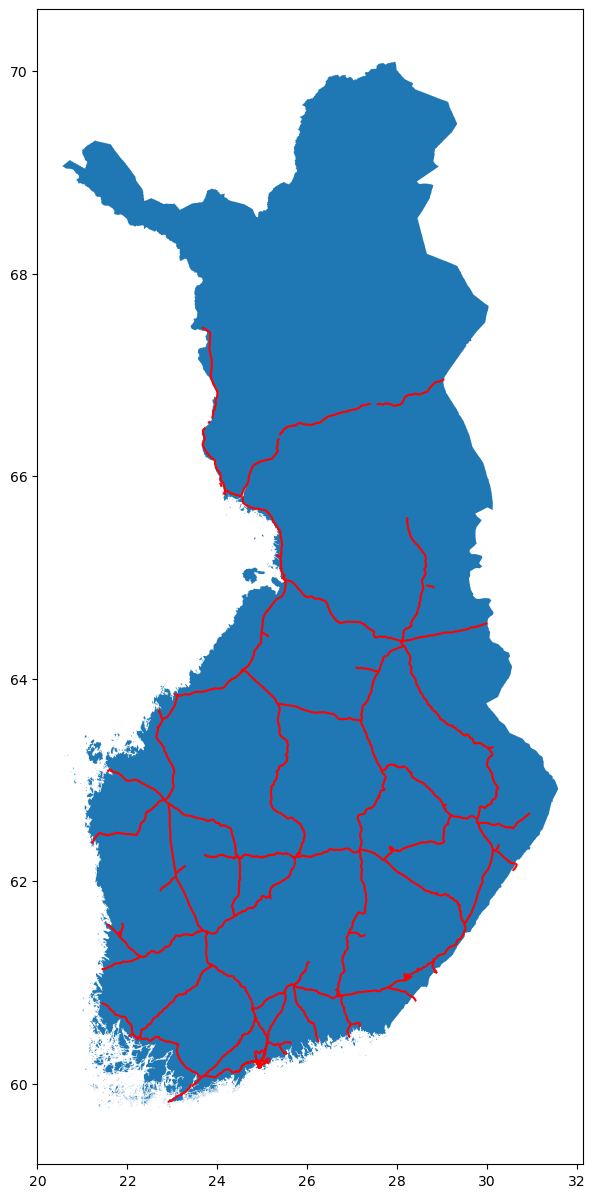

In [8]:
# There are some resources for maps are provided.

fig, ax = plt.subplots(figsize=(15,15))

# https://geodata.mit.edu/catalog/stanford-mb800bj2863
finlandBoundary  = gpd.read_file('solution_files/data/FIN_adm0.shp')
finlandBoundary.plot(ax=ax)

# https://mapcruzin.com/free-finland-arcgis-maps-shapefiles.htm
street_map = gpd.read_file('solution_files/railways/railways.shp')
street_map.plot(ax=ax,color = 'red')

plt.show()

In [9]:
geometry = [Point(xy) for xy in zip(stations['longitude'], stations['latitude'])]

In [10]:
crs = {'init':'epsg:4326'}
geo_df = gpd.GeoDataFrame(stations,
                          crs=crs,
                          geometry=geometry) 

C:\Users\alioz\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


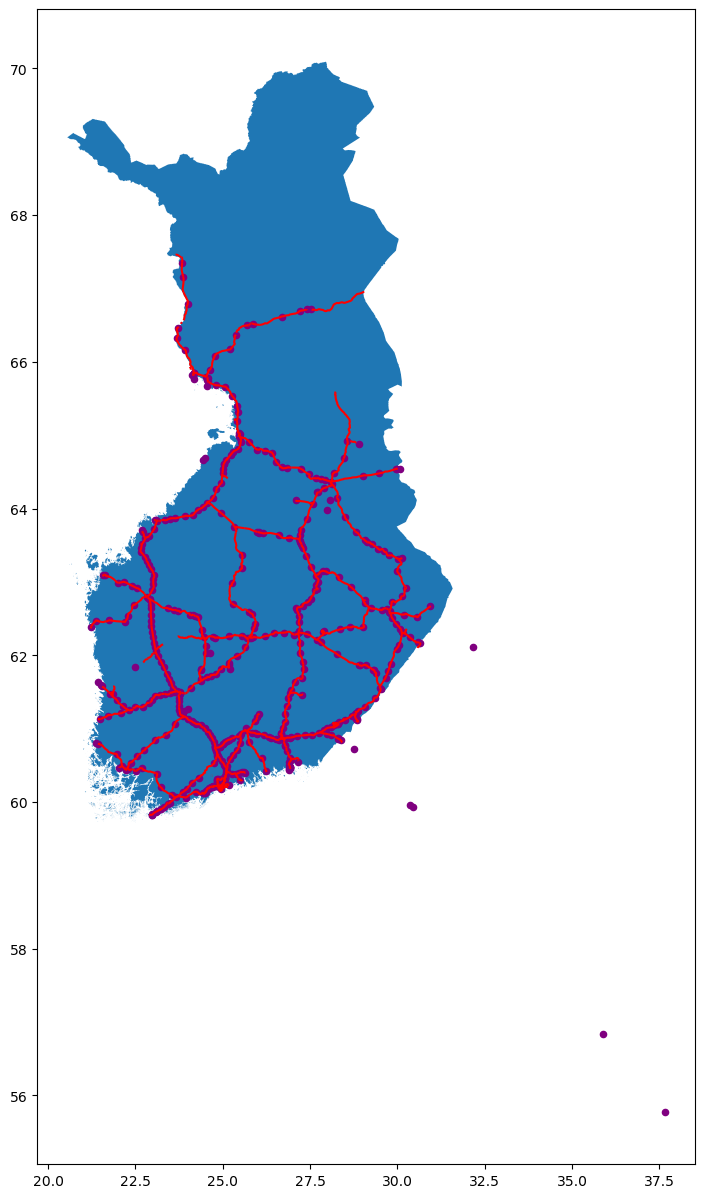

In [11]:
fig, ax = plt.subplots(figsize=(15,15))

finlandBoundary.plot(ax=ax)
street_map.plot(ax=ax,color = 'red')

geo_df.plot(ax=ax, 
                   markersize=20, 
                   color='purple', 
                   marker='o')
plt.show()

In [12]:
# There are some stations outside the boarder deteriorating the map
stations.sort_values(by = ["longitude", "latitude"], ascending = False)

,passengerTraffic,type,stationName,stationShortCode,stationUICCode,countryCode,longitude,latitude
269,True,STATION,Moskova_(Leningradski),MVA,6007,RU,37.655278,55.777111
493,True,STATION,Tver,TVE,9999,RU,35.892800,56.835200
344,False,STATION,Petroskoi / Petrozavodsk,PRK,1000,RU,32.176808,62.116980
78,False,STATION,Ilomantsi,ILO,459,FI,30.941562,62.666381
544,False,STATION,Värtsilä,VRS,2410,RU,30.652785,62.165755
...,...,...,...,...,...,...,...,...
500,False,STATION,Uusikaupunki,UKP,121,FI,21.425685,60.797364
455,False,STATION,Tahkoluoto,TKO,702,FI,21.417336,61.633918
309,False,TURNOUT_IN_THE_OPEN_LINE,Närpiö,NÄR,268,FI,21.363959,62.468168
30,False,STATION,Hangonsaari,HGS,1020,FI,21.360988,60.799200


In [13]:
df_all["route"] = df_all["trainNumber"].astype("str") + "_" + df_all["departureDate"].astype("str")

In [14]:
# Those routes including a station outside the finland are removed.
outside_routes = set(df_all[df_all.stationShortCode.isin(
    set(stations[stations.countryCode != "FI"].stationShortCode))].route)

In [15]:
df_all = df_all[~df_all.route.isin(outside_routes)]

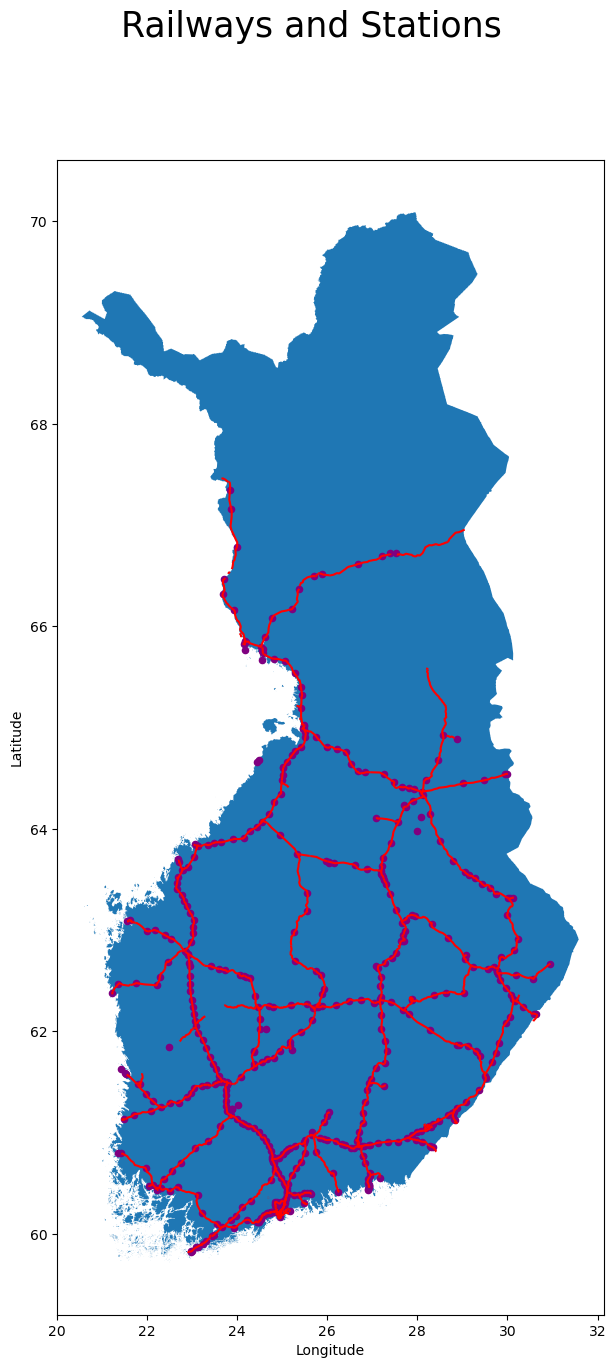

In [16]:
# Railmap does not cover all the stations since it is a little bit old.
geo_df = geo_df[geo_df.countryCode == "FI"]


fig, ax = plt.subplots(figsize=(15,15))

finlandBoundary.plot(ax=ax)
street_map.plot(ax=ax,color = 'red')

geo_df.plot(ax=ax, 
                   markersize=20, 
                   color='purple', 
                   marker='o')

fig.suptitle('Railways and Stations', fontsize=25)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize='medium')

plt.show()

In [17]:
# Most of cancelled departure and arrivals are due to the fact that
# their trains are cancelled. 
sum_cancelled = df_all.groupby("stationShortCode")['cancelled'].sum().reset_index()
sum_cancelled.columns = ['stationShortCode', 'sumCancelled']


geo_df = pd.merge(geo_df, sum_cancelled, on='stationShortCode', how='left')
geo_df['sumCancelled'].fillna(0, inplace=True)
geo_df.sort_values("sumCancelled", ascending = False)

,passengerTraffic,type,stationName,stationShortCode,stationUICCode,countryCode,longitude,latitude,geometry,sumCancelled
331,True,STATION,Pasila asema,PSL,10,FI,24.933521,60.198689,POINT (24.93352 60.19869),5288.0
47,True,STATION,Helsinki asema,HKI,1,FI,24.941249,60.172097,POINT (24.94125 60.17210),2644.0
58,True,STATION,Huopalahti,HPL,72,FI,24.893523,60.218350,POINT (24.89352 60.21835),2496.0
48,False,STATION,Helsinki Kivihaka,KHK,1028,FI,24.917191,60.209813,POINT (24.91719 60.20981),2496.0
73,True,STATION,Ilmala asema,ILA,9,FI,24.920636,60.208134,POINT (24.92064 60.20813),2496.0
...,...,...,...,...,...,...,...,...,...,...
510,False,STATION,Vartius-raja,VUR,949,FI,29.989741,64.545906,POINT (29.98974 64.54591),0.0
197,False,STATION,Kuusikkoniemi,KSN,1356,FI,27.919899,64.392909,POINT (27.91990 64.39291),0.0
512,False,STATION,Vaskiluoto,VSK,291,FI,21.564228,63.089086,POINT (21.56423 63.08909),0.0
377,False,STATION,Rantasalmi,RMI,524,FI,28.276594,62.014348,POINT (28.27659 62.01435),0.0


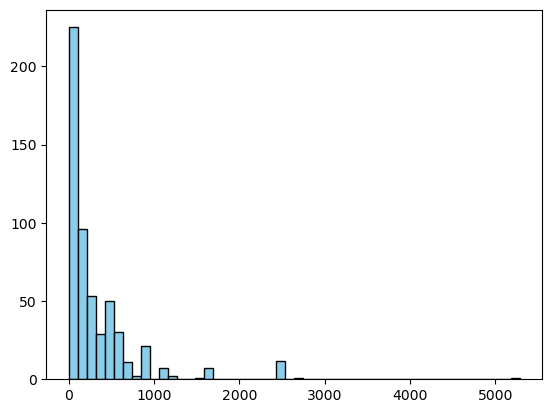

In [18]:
plt.hist(geo_df.sumCancelled, bins = 50, color='skyblue', edgecolor='black')
plt.show()

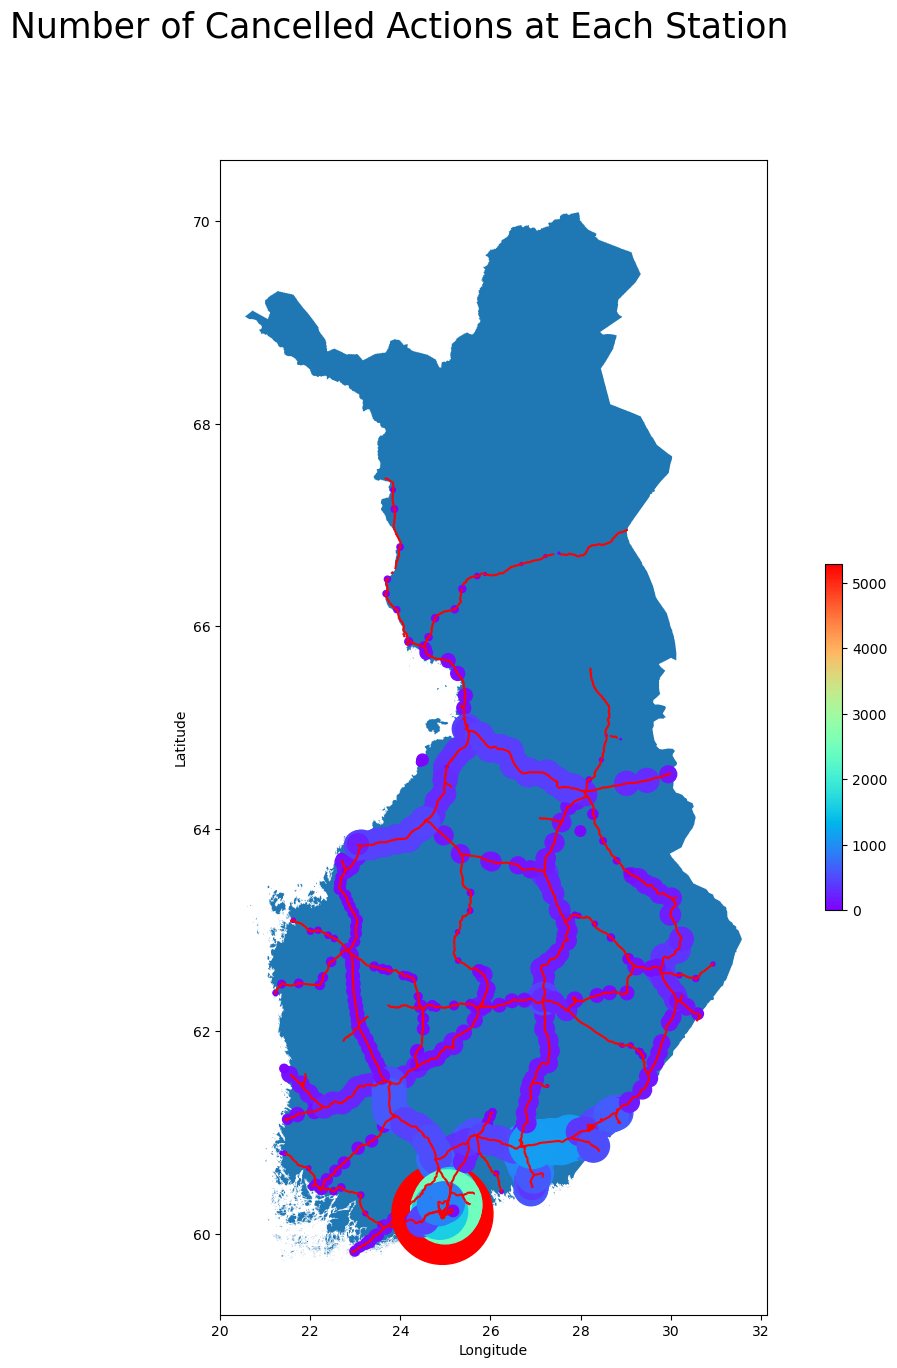

In [19]:
fig, ax = plt.subplots(figsize=(15,15))

finlandBoundary.plot(ax=ax)
street_map.plot(ax=ax,color = 'red')

geo_df.plot(column = 'sumCancelled', ax=ax
            , cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 'sumCancelled')

fig.suptitle('Number of Cancelled Actions at Each Station', fontsize=25)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize='medium')

plt.show()

In [20]:
# As we get closer to the southern part, many stations experienced
# cancellations.

geo_df.sort_values("sumCancelled", ascending = False).head(30)

,passengerTraffic,type,stationName,stationShortCode,stationUICCode,countryCode,longitude,latitude,geometry,sumCancelled
331,True,STATION,Pasila asema,PSL,10,FI,24.933521,60.198689,POINT (24.93352 60.19869),5288.0
47,True,STATION,Helsinki asema,HKI,1,FI,24.941249,60.172097,POINT (24.94125 60.17210),2644.0
58,True,STATION,Huopalahti,HPL,72,FI,24.893523,60.218350,POINT (24.89352 60.21835),2496.0
48,False,STATION,Helsinki Kivihaka,KHK,1028,FI,24.917191,60.209813,POINT (24.91719 60.20981),2496.0
73,True,STATION,Ilmala asema,ILA,9,FI,24.920636,60.208134,POINT (24.92064 60.20813),2496.0
41,False,STATION,Havukoski,HVK,1334,FI,25.051833,60.308402,POINT (25.05183 60.30840),2478.0
51,True,STATION,Hiekkaharju,HKH,556,FI,25.049104,60.303081,POINT (25.04910 60.30308),2473.0
465,True,STATION,Tikkurila asema,TKL,18,FI,25.044055,60.292166,POINT (25.04406 60.29217),2466.0
361,True,STOPPING_POINT,Puistola,PLA,553,FI,25.036683,60.276313,POINT (25.03668 60.27631),2464.0
456,True,STOPPING_POINT,Tapanila,TNA,552,FI,25.030033,60.263900,POINT (25.03003 60.26390),2463.0


In [21]:
df_all[(df_all.stationShortCode == "PSL") & (df_all.cancelled == True)]

,trainNumber,departureDate,trainCategory,cancelledTrain,stationShortCode,type,cancelled,scheduledTime,actualTime,differenceInMinutes,categoryName,route
36775,8701,2021-03-01,Commuter,True,PSL,ARRIVAL,True,2021-03-01 15:31:00+00:00,NaT,NaN,NaN,8701_2021-03-01
36776,8701,2021-03-01,Commuter,True,PSL,DEPARTURE,True,2021-03-01 15:32:00+00:00,NaT,NaN,NaN,8701_2021-03-01
36833,8701,2021-03-01,Commuter,True,PSL,ARRIVAL,True,2021-03-01 16:25:00+00:00,NaT,NaN,NaN,8701_2021-03-01
36834,8701,2021-03-01,Commuter,True,PSL,DEPARTURE,True,2021-03-01 16:26:00+00:00,NaT,NaN,NaN,8701_2021-03-01
43409,8897,2021-03-01,Commuter,True,PSL,ARRIVAL,True,2021-03-01 15:39:00+00:00,NaT,NaN,NaN,8897_2021-03-01
...,...,...,...,...,...,...,...,...,...,...,...,...
1943868,9666,2021-03-31,Commuter,True,PSL,DEPARTURE,True,2021-03-31 10:44:00+00:00,NaT,NaN,NaN,9666_2021-03-31
1957453,64151,2021-03-31,Shunting,True,PSL,ARRIVAL,True,2021-03-31 20:10:00+00:00,NaT,NaN,NaN,64151_2021-03-31
1957454,64151,2021-03-31,Shunting,True,PSL,DEPARTURE,True,2021-03-31 20:10:00+00:00,NaT,NaN,NaN,64151_2021-03-31
1957531,64431,2021-03-31,Shunting,True,PSL,ARRIVAL,True,2021-03-31 13:49:00+00:00,NaT,NaN,NaN,64431_2021-03-31


In [22]:
df_all[(df_all.stationShortCode == "PSL") & (df_all.departureDate == "2021-03-19")]

,trainNumber,departureDate,trainCategory,cancelledTrain,stationShortCode,type,cancelled,scheduledTime,actualTime,differenceInMinutes,categoryName,route
1150317,1,2021-03-19,Long-distance,False,PSL,ARRIVAL,False,2021-03-19 05:02:00+00:00,2021-03-19 05:01:38+00:00,0.0,NaN,1_2021-03-19
1150318,1,2021-03-19,Long-distance,False,PSL,DEPARTURE,False,2021-03-19 05:03:00+00:00,2021-03-19 05:08:38+00:00,6.0,NaN,1_2021-03-19
1150451,3,2021-03-19,Long-distance,False,PSL,ARRIVAL,False,2021-03-19 08:24:00+00:00,2021-03-19 08:24:21+00:00,0.0,NaN,3_2021-03-19
1150452,3,2021-03-19,Long-distance,False,PSL,DEPARTURE,False,2021-03-19 08:25:00+00:00,2021-03-19 08:25:20+00:00,0.0,NaN,3_2021-03-19
1150715,4,2021-03-19,Long-distance,False,PSL,ARRIVAL,False,2021-03-19 08:34:00+00:00,2021-03-19 08:33:39+00:00,0.0,NaN,4_2021-03-19
...,...,...,...,...,...,...,...,...,...,...,...,...
1219702,65012,2021-03-19,Shunting,False,PSL,DEPARTURE,False,2021-03-19 10:10:05+00:00,2021-03-19 10:08:14+00:00,-2.0,NaN,65012_2021-03-19
1219705,65202,2021-03-19,Shunting,False,PSL,ARRIVAL,False,2021-03-19 11:47:15+00:00,2021-03-19 11:40:53+00:00,-6.0,NaN,65202_2021-03-19
1219706,65202,2021-03-19,Shunting,False,PSL,DEPARTURE,False,2021-03-19 11:47:15+00:00,2021-03-19 11:42:53+00:00,-4.0,NaN,65202_2021-03-19
1219709,65203,2021-03-19,Shunting,False,PSL,ARRIVAL,False,2021-03-19 11:56:34+00:00,2021-03-19 11:50:42+00:00,-6.0,NaN,65203_2021-03-19


In [23]:
# On the 18th and 19th of March, 2021;  Pasila railway was particularly
# cancelled for "commuter" train types, most likely due to lockdowns.

In [24]:
df_all[(df_all.stationShortCode == "PSL") & (df_all.departureDate.isin(["2021-03-18","2021-03-19"]))].cancelled.sum()

4400

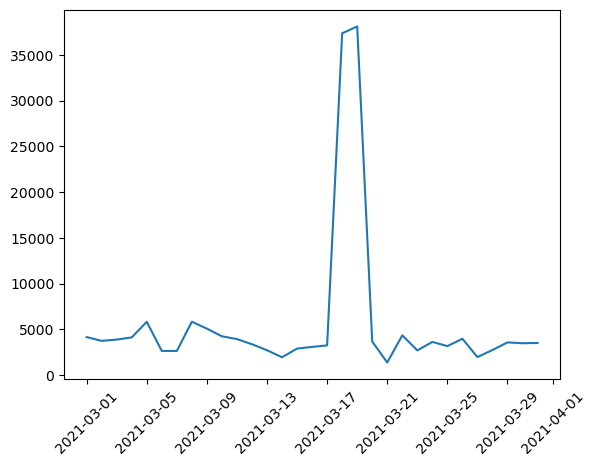

In [25]:
# Those two dates clearly stand out even when we line plot the daily sum
dateCancelled = df_all.groupby("departureDate").cancelled.sum().reset_index()
plt.plot(dateCancelled.departureDate, dateCancelled['cancelled'])

plt.xticks(rotation=45)
plt.show()

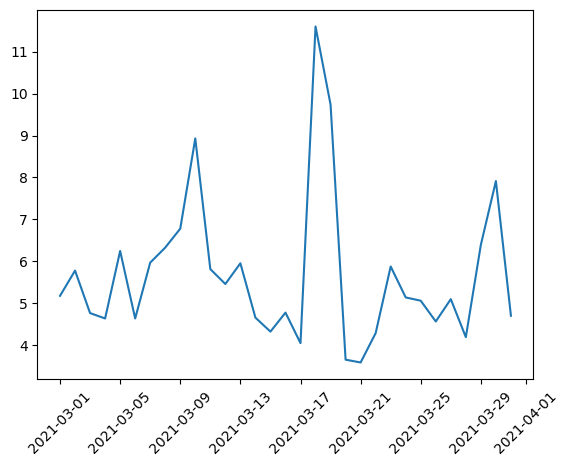

In [26]:
dateAvgDelay = df_all[df_all.differenceInMinutes > 0].groupby("departureDate").differenceInMinutes.mean().reset_index()
plt.plot(dateAvgDelay.departureDate, dateAvgDelay['differenceInMinutes'])

plt.xticks(rotation=45)
plt.show()

In [27]:
# If we throw away those two days we can get a different picture

sum_cancelled_lockd = df_all[~df_all.departureDate.isin(["2021-03-18","2021-03-19"])].groupby("stationShortCode")['cancelled'].sum().reset_index()
sum_cancelled_lockd.columns = ['stationShortCode', 'sumCancelled_lc']


geo_df = pd.merge(geo_df, sum_cancelled_lockd, on='stationShortCode', how='left')
geo_df['sumCancelled_lc'].fillna(0, inplace=True)


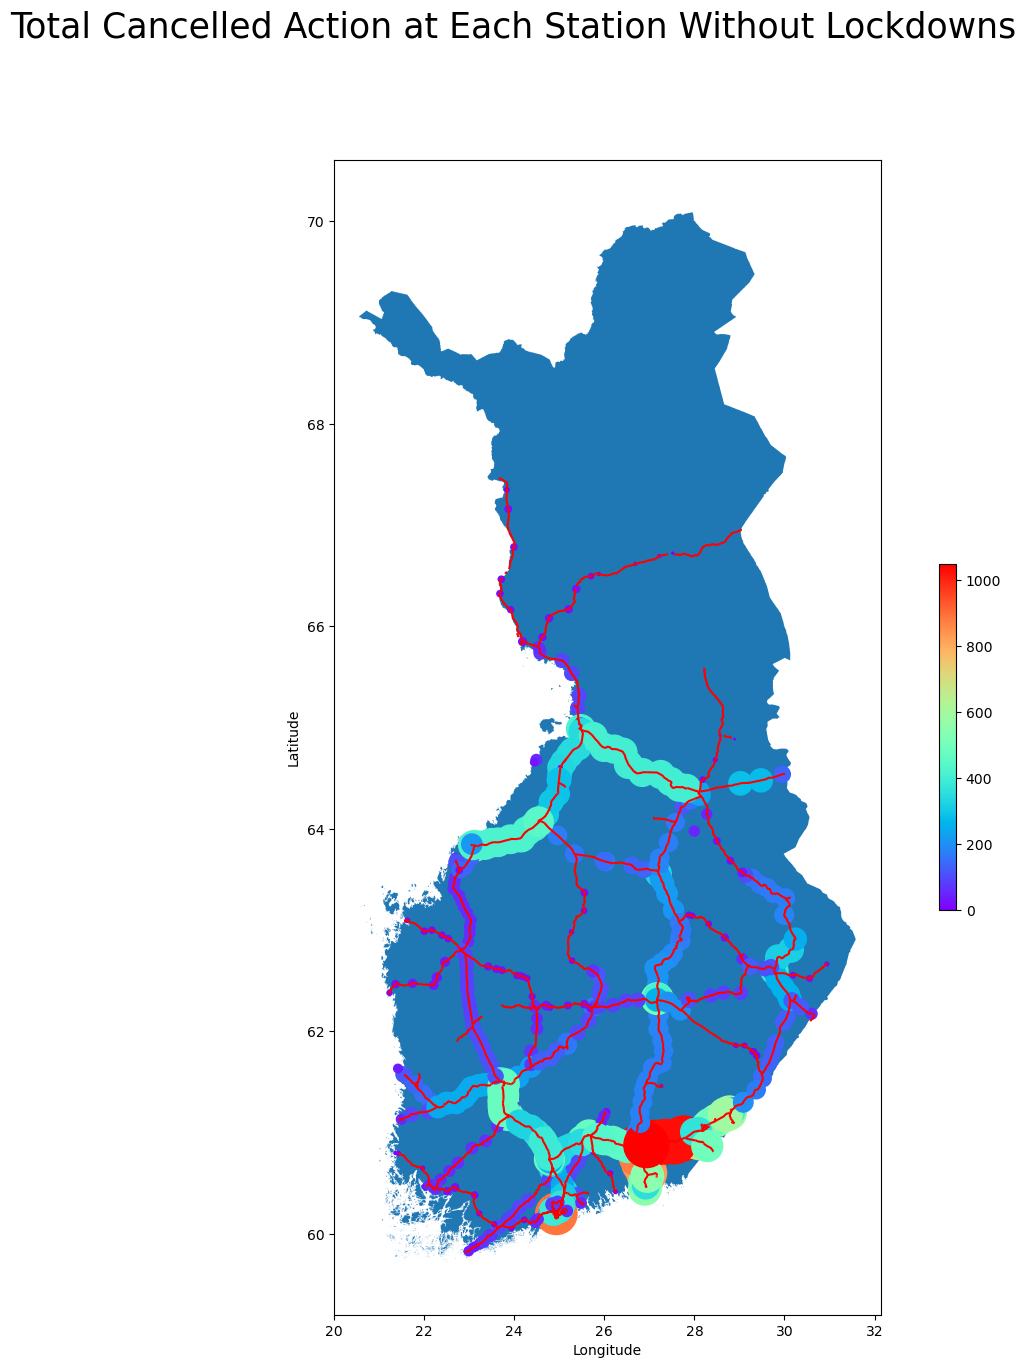

In [28]:
fig, ax = plt.subplots(figsize=(15,15))

finlandBoundary.plot(ax=ax)
street_map.plot(ax=ax,color = 'red')

geo_df.plot(column = 'sumCancelled_lc', ax=ax
            , cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 'sumCancelled_lc')

fig.suptitle('Total Cancelled Action at Each Station Without Lockdowns', fontsize=25)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize='medium')

plt.show()

In [29]:
sum_cancelled_lockd.sort_values("sumCancelled_lc", ascending=False).head(10)

,stationShortCode,sumCancelled_lc
159,KTH,1048
456,UTI,1048
172,KUV,1048
142,KPA,1039
223,LÄ,1033
120,KJR,1030
415,TA,1029
326,PSL,888
233,MKI,878
300,PIO,878


In [30]:
# We can also further examine the delay. For this plot, it makes more 
# sense to use not cancelled actions and positive "differenceInMinutes"

average_delay = df_all[df_all.differenceInMinutes > 0].groupby("stationShortCode")['differenceInMinutes'].mean().reset_index()
average_delay.columns = ['stationShortCode', 'avgDelay']

geo_df = pd.merge(geo_df, average_delay, on='stationShortCode', how='left')
geo_df['avgDelay'].fillna(0, inplace=True)

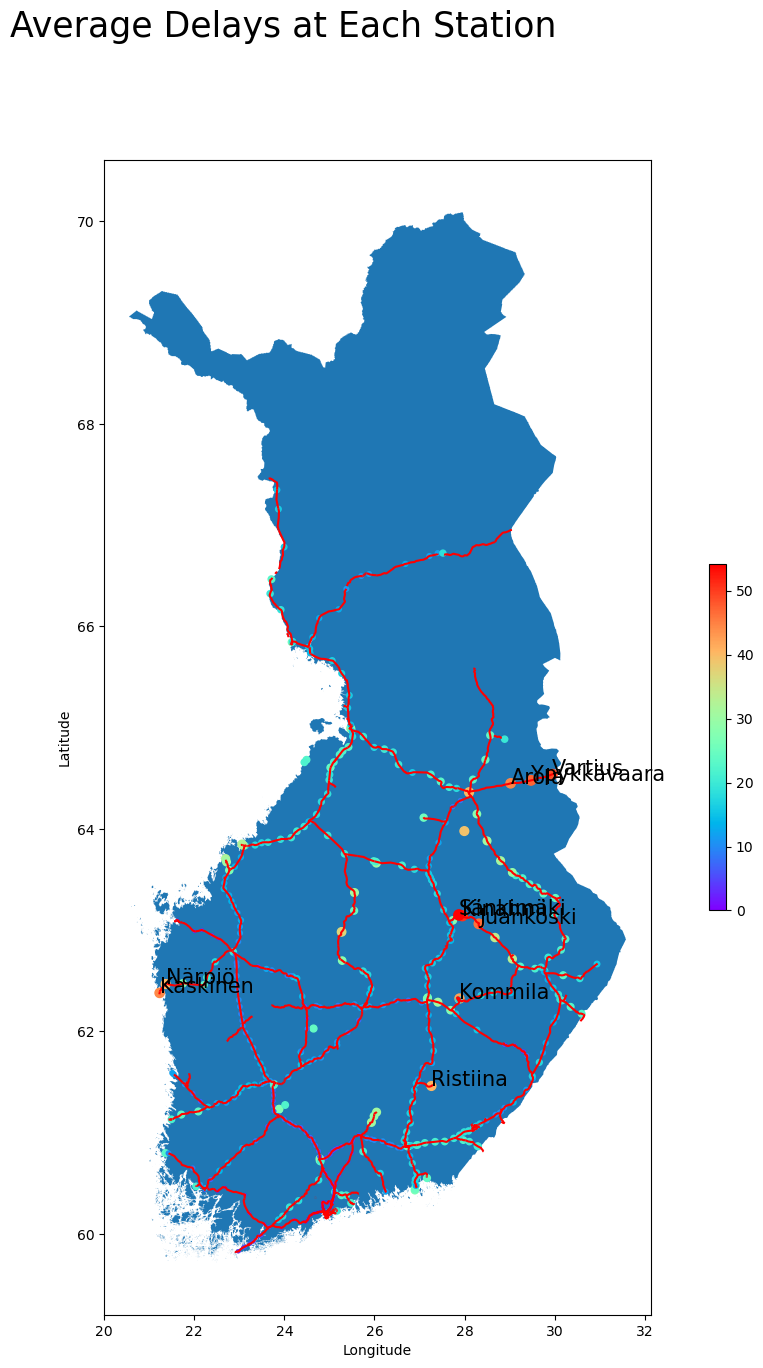

In [31]:
fig, ax = plt.subplots(figsize=(15,15))

finlandBoundary.plot(ax=ax)
street_map.plot(ax=ax,color = 'red')

geo_df.plot(column = 'avgDelay', ax=ax
            , cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 'avgDelay')

fig.suptitle('Average Delays at Each Station', fontsize=25)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize='medium')

# The Worst 10 Stations
top10 = geo_df.sort_values("avgDelay", ascending= False).head(10)
x_co = top10.longitude
y_co = top10.latitude
name = top10.stationName

for x, y, label in zip(x_co,y_co, name):
    ax.annotate(label, xy=(x, y), fontsize=15)

    
plt.show()

In [32]:
# As can be seen from the map, there are some particular stations 
# with extreme delays
geo_df.sort_values("avgDelay", ascending=False).head(10)

,passengerTraffic,type,stationName,stationShortCode,stationUICCode,countryCode,longitude,latitude,geometry,sumCancelled,sumCancelled_lc,avgDelay
444,False,TURNOUT_IN_THE_OPEN_LINE,Sänkimäki,SKM,872,FI,27.874879,63.150850,POINT (27.87488 63.15085),16.0,16.0,54.178571
147,False,TURNOUT_IN_THE_OPEN_LINE,Kinahmi,KNH,873,FI,27.951398,63.142738,POINT (27.95140 63.14274),14.0,14.0,50.590909
509,False,STATION,Vartius,VUS,941,FI,29.948090,64.540163,POINT (29.94809 64.54016),147.0,139.0,48.756522
543,False,STATION,Ypykkävaara,YPY,940,FI,29.474923,64.479932,POINT (29.47492 64.47993),294.0,278.0,47.125581
96,False,STATION,Juankoski,JKI,414,FI,28.318074,63.063182,POINT (28.31807 63.06318),14.0,14.0,46.170213
9,False,STATION,Arola,ARO,939,FI,29.022513,64.450787,POINT (29.02251 64.45079),299.0,283.0,44.463115
122,False,STATION,Kaskinen,KSK,267,FI,21.229972,62.381061,POINT (21.22997 62.38106),15.0,13.0,44.400000
166,False,STATION,Kommila,KMM,500,FI,27.887689,62.325423,POINT (27.88769 62.32542),32.0,30.0,42.173913
305,False,TURNOUT_IN_THE_OPEN_LINE,Närpiö,NÄR,268,FI,21.363959,62.468168,POINT (21.36396 62.46817),30.0,26.0,40.454545
397,False,STATION,Ristiina,RST,770,FI,27.264338,61.461611,POINT (27.26434 61.46161),4.0,4.0,40.214286


In [33]:
# We can also examine the hourly plot.
df_all['actualTime_hourly'] = df_all['actualTime'].dt.strftime('%Y-%m-%d %H:00')

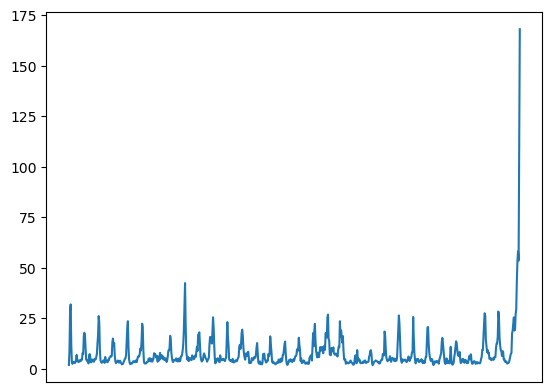

In [34]:
dateAvgDelay = df_all[df_all.differenceInMinutes > 0].groupby("actualTime_hourly").differenceInMinutes.mean().reset_index()
plt.plot(dateAvgDelay.actualTime_hourly, dateAvgDelay['differenceInMinutes'])

plt.tick_params(bottom  = False, labelbottom = False)
plt.show()

In [35]:
# Easter is celebrated in Finnland on the 31st of March. People coming from their vacations and covid could have led to
# the 
# https://global-monitoring.com/gm/page/events/epidemic-0001997.uWoUS8h5ZPAP.html?lang=en
# Update 2021-03-31: Finnish authorities stated on Wednesday (31 March)
# that the current entry restrictions have been extended until at least
# 30 April. Entry to Finland from all Schengen countries except Iceland
# is possible only for essential reasons.

dateAvgDelay.sort_values("differenceInMinutes", ascending=False)

,actualTime_hourly,differenceInMinutes
757,2021-04-01 11:00,168.000000
756,2021-04-01 10:00,107.142857
754,2021-04-01 08:00,58.000000
755,2021-04-01 09:00,53.500000
753,2021-04-01 07:00,52.951220
...,...,...
478,2021-03-20 20:00,1.935780
367,2021-03-16 05:00,1.845316
0,2021-02-28 22:00,1.795455
612,2021-03-26 10:00,1.757618


### Delay Causes

In [36]:
avgDelayCauses = df_all[df_all.differenceInMinutes > 0].groupby("categoryName")['differenceInMinutes'].mean().reset_index()

In [37]:
avgDelayCauses

,categoryName,differenceInMinutes
0,Accident,36.666667
1,Delay in train formation,37.319209
2,Passenger service,6.613488
3,"Rolling stock, locomotives and wagons",38.639262
4,Staff,32.329545
5,Telegram,9.724638
6,Timetable and traffic,35.484581
7,Track structure,17.403805
8,Track work,15.479532
9,Traction equipment,44.536184


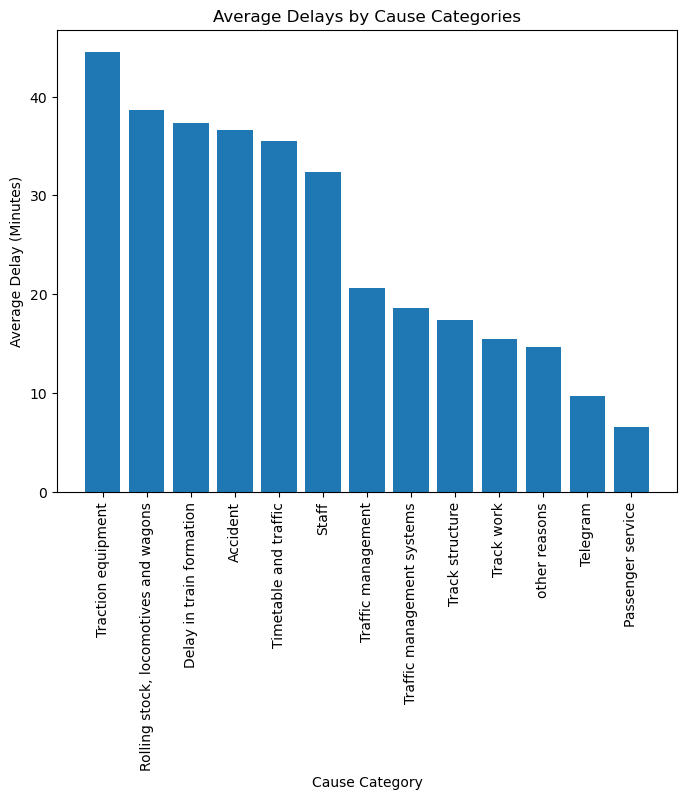

In [38]:
avgDelayCauses = avgDelayCauses.sort_values(by='differenceInMinutes', ascending=False)

plt.figure(figsize=(8, 6))
plt.bar(avgDelayCauses['categoryName'], avgDelayCauses['differenceInMinutes'])
plt.xlabel('Cause Category')
plt.ylabel('Average Delay (Minutes)')
plt.title('Average Delays by Cause Categories')

plt.xticks(rotation=90)
plt.show()

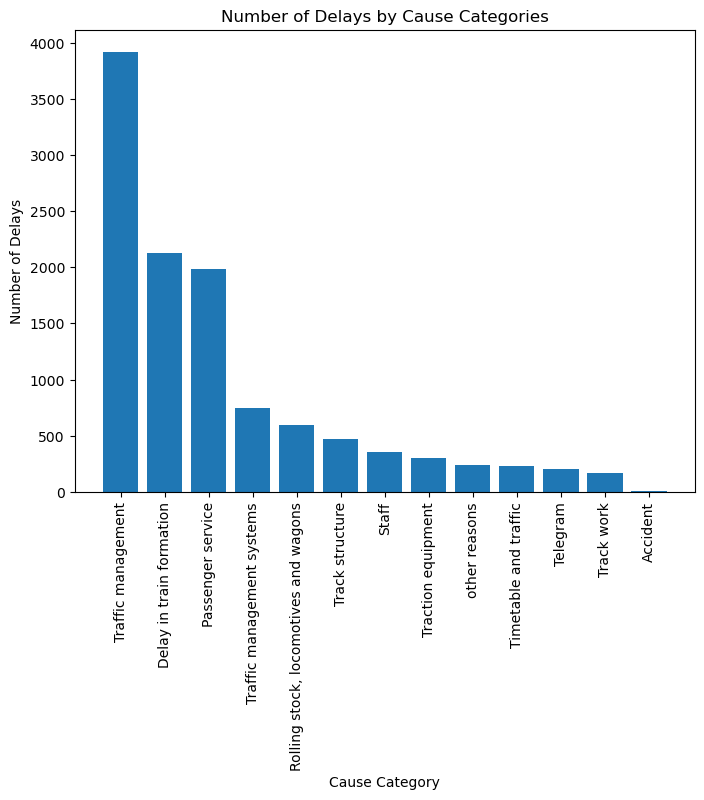

In [39]:
# Even though accidents are one of the mojor reasons for long delays,
# they don't seem to occur that often. Traffic management is the main
# reason for delays. Delay in train formation and passenger services
# seem to cause delays too which can be reduced by taking actions accordingly


numDelayCauses = df_all[df_all.differenceInMinutes > 0].groupby("categoryName")["trainNumber"].count().reset_index()
numDelayCauses = numDelayCauses.sort_values(by='trainNumber', ascending=False)
plt.figure(figsize=(8, 6))
plt.bar(numDelayCauses['categoryName'], numDelayCauses['trainNumber'])
plt.xlabel('Cause Category')
plt.ylabel('Number of Delays')
plt.title('Number of Delays by Cause Categories')

plt.xticks(rotation=90)
plt.show()

In [40]:
# Most of accidents seemed to occur at the station RI
df_all[df_all.categoryName == "Accident"]

,trainNumber,departureDate,trainCategory,cancelledTrain,stationShortCode,type,cancelled,scheduledTime,actualTime,differenceInMinutes,categoryName,route,actualTime_hourly
15529,2296,2021-03-01,Cargo,False,KVT,ARRIVAL,False,2021-03-01 19:08:00+00:00,2021-03-01 19:49:15+00:00,41.0,Accident,2296_2021-03-01,2021-03-01 19:00
69804,24,2021-03-02,Long-distance,False,RI,DEPARTURE,False,2021-03-02 14:50:00+00:00,2021-03-02 14:59:44+00:00,10.0,Accident,24_2021-03-02,2021-03-02 14:00
72963,65,2021-03-02,Long-distance,False,VAA,ARRIVAL,False,2021-03-02 16:39:00+00:00,2021-03-02 17:14:55+00:00,36.0,Accident,65_2021-03-02,2021-03-02 17:00
279341,263,2021-03-05,Long-distance,False,KLI,ARRIVAL,False,2021-03-06 06:44:00+00:00,2021-03-06 06:55:37+00:00,12.0,Accident,263_2021-03-05,2021-03-06 06:00
407787,930,2021-03-07,Long-distance,False,TKU,ARRIVAL,False,2021-03-07 18:55:00+00:00,2021-03-07 20:16:42+00:00,82.0,Accident,930_2021-03-07,2021-03-07 20:00
767779,9687,2021-03-12,Commuter,False,RI,ARRIVAL,False,2021-03-12 14:05:00+00:00,2021-03-12 14:09:23+00:00,4.0,Accident,9687_2021-03-12,2021-03-12 14:00
1029865,712,2021-03-17,Long-distance,False,KAJ,ARRIVAL,False,2021-03-17 18:31:00+00:00,2021-03-17 18:43:43+00:00,13.0,Accident,712_2021-03-17,2021-03-17 18:00
1092064,187,2021-03-18,Long-distance,False,RI,DEPARTURE,False,2021-03-18 20:52:00+00:00,2021-03-18 21:18:49+00:00,27.0,Accident,187_2021-03-18,2021-03-18 21:00
1661948,48,2021-03-27,Long-distance,False,TL,DEPARTURE,False,2021-03-27 13:17:00+00:00,2021-03-27 15:02:19+00:00,105.0,Accident,48_2021-03-27,2021-03-27 15:00


In [41]:
average_delay_tm = df_all[(df_all.differenceInMinutes > 0) & (df_all.categoryName == "Traffic management")].groupby("stationShortCode")['differenceInMinutes'].mean().reset_index()
average_delay_tm.columns = ['stationShortCode', 'avgDelay_Traffic']

geo_df = pd.merge(geo_df, average_delay_tm, on='stationShortCode', how='left')
geo_df['avgDelay_Traffic'].fillna(0, inplace=True)

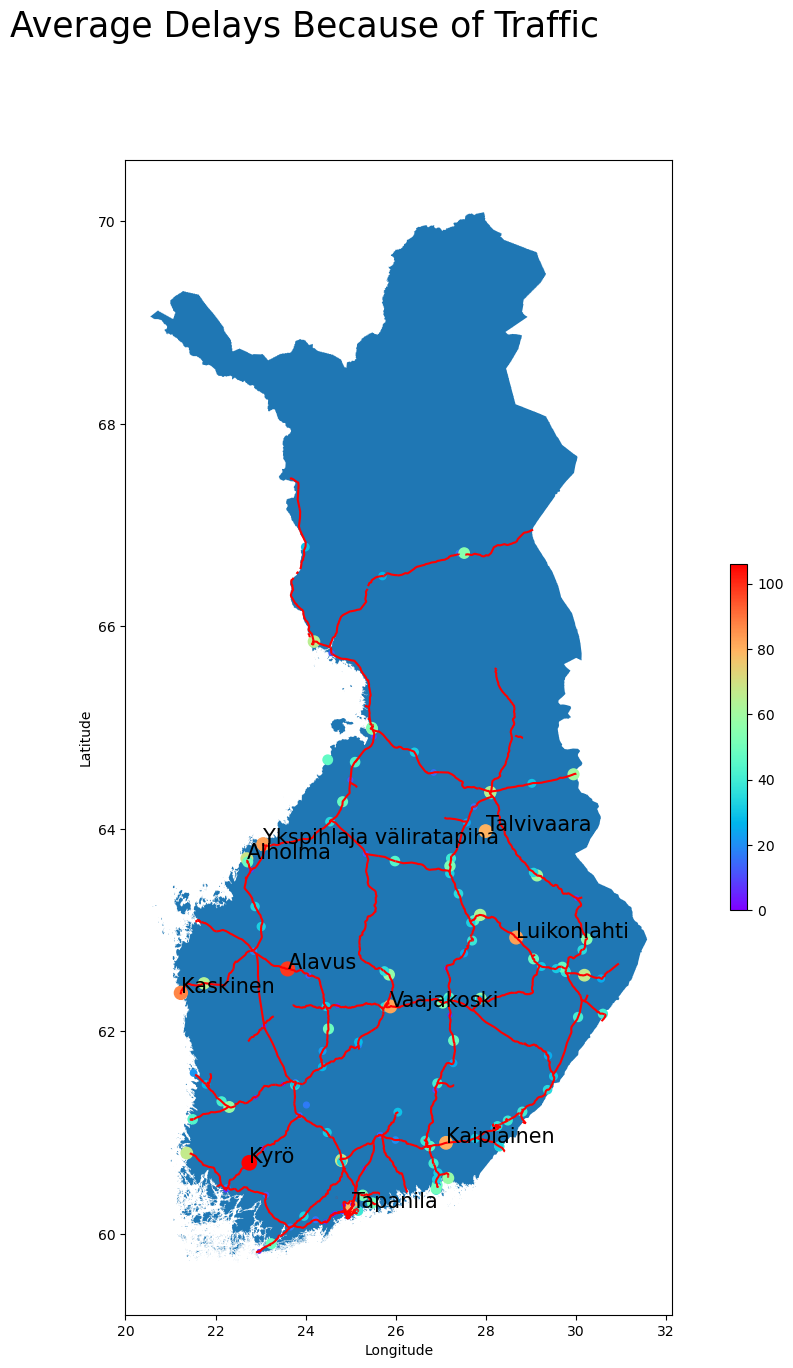

In [42]:
fig, ax = plt.subplots(figsize=(15,15))

finlandBoundary.plot(ax=ax)
street_map.plot(ax=ax,color = 'red')

geo_df.plot(column = 'avgDelay_Traffic', ax=ax
            , cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 'avgDelay_Traffic')

fig.suptitle('Average Delays Because of Traffic', fontsize=25)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize='medium')

# The Worst 10 Stations
top10 = geo_df.sort_values("avgDelay_Traffic", ascending= False).head(10)
x_co = top10.longitude
y_co = top10.latitude
name = top10.stationName

for x, y, label in zip(x_co,y_co, name):
    ax.annotate(label, xy=(x, y), fontsize=15)

    
plt.show()

# Anomaly Detection

To quantify the performance of an anomaly detection, we need to make predictions and analyse how the model performance change. In our case, it can make sense to predict the total delay. 

In [43]:
route_time = df_all.groupby(['trainNumber', 'route', 'trainCategory'])["scheduledTime"].agg(['max','min'])

route_time['difference']= (route_time["max"] - route_time["min"]) / pd.Timedelta(minutes=1)


In [44]:
route_time["numStations"] = df_all[df_all.cancelled == False].groupby(['trainNumber', 'route', 'trainCategory'])["stationShortCode"].nunique()
route_time["sumDelay"] = df_all[df_all.differenceInMinutes > 0].groupby(['trainNumber', 'route',
                                                                         'trainCategory'])["differenceInMinutes"].sum()

route_time = route_time[route_time["difference"].notna() & 
                       route_time["numStations"].notna()]

route_time["sumDelay"] = route_time["sumDelay"].fillna(0)

In [45]:
# Let's first build a simple model making use of the features and dates we discussed so far assuming that
# we know the number of cancellations for each route.

route_time = pd.merge(route_time.reset_index(),
         df_all.groupby("route")["cancelled"].sum().reset_index(),
         how = "left", on = "route")

route_time[['trainNumber', 'date']] = route_time['route'].str.split('_', expand = True)

route_time.date = pd.to_datetime(route_time.date)

route_time

,trainNumber,route,trainCategory,max,min,difference,numStations,sumDelay,cancelled,date
0,1,1_2021-03-01,Long-distance,2021-03-01 09:39:00+00:00,2021-03-01 04:57:00+00:00,282.0,68.0,170.0,0,2021-03-01
1,1,1_2021-03-02,Long-distance,2021-03-02 09:39:00+00:00,2021-03-02 04:57:00+00:00,282.0,68.0,112.0,0,2021-03-02
2,1,1_2021-03-03,Long-distance,2021-03-03 09:39:00+00:00,2021-03-03 04:57:00+00:00,282.0,68.0,195.0,0,2021-03-03
3,1,1_2021-03-04,Long-distance,2021-03-04 09:39:00+00:00,2021-03-04 04:57:00+00:00,282.0,68.0,61.0,0,2021-03-04
4,1,1_2021-03-05,Long-distance,2021-03-05 09:39:00+00:00,2021-03-05 04:57:00+00:00,282.0,68.0,213.0,0,2021-03-05
...,...,...,...,...,...,...,...,...,...,...
46668,88742,88742_2021-03-26,Commuter,2021-03-25 23:51:00+00:00,2021-03-25 22:48:00+00:00,63.0,30.0,290.0,0,2021-03-26
46669,89646,89646_2021-03-02,Commuter,2021-03-02 08:48:00+00:00,2021-03-02 07:55:00+00:00,53.0,27.0,1331.0,0,2021-03-02
46670,89720,89720_2021-03-05,Commuter,2021-03-05 19:49:00+00:00,2021-03-05 18:55:00+00:00,54.0,27.0,54.0,0,2021-03-05
46671,89728,89728_2021-03-04,Commuter,2021-03-04 21:19:00+00:00,2021-03-04 20:25:00+00:00,54.0,27.0,31.0,0,2021-03-04


In [46]:
route_time['is_weekend'] = route_time['min'].dt.dayofweek // 5  # 1 if weekend, 0 if not
route_time['hour'] = route_time['min'].dt.hour
route_time['isMin_18_19_March_2021'] = ((route_time['min'].dt.month == 3) & 
                              (route_time['min'].dt.day.isin([18, 19])) & 
                              (route_time['min'].dt.year == 2021))


route_time["isMax_1_April_2021"] = ((route_time['max'].dt.month == 4) & 
                          (route_time['max'].dt.day == 1) & 
                          (route_time['max'].dt.year == 2021))

In [47]:
regData = pd.get_dummies(route_time[["difference", "numStations", "sumDelay", "cancelled", 
            "is_weekend", "hour", "isMin_18_19_March_2021", "isMax_1_April_2021", "trainCategory",
                                    ]])

regData['trainNumber'] = route_time['trainNumber']

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X, y = regData.drop("sumDelay", axis=1), regData[['sumDelay']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, train_size=0.8)
lr = LinearRegression()
lr.fit(X_train.drop("trainNumber", axis=1), y_train)
preds = lr.predict(X_test.drop("trainNumber", axis=1))
rmse = mean_squared_error(y_test, preds, squared=False)

print(round(rmse, 3))

404.208


## Univariate Meadian Absolute Deviations

Meadian Absolute Deviation (MAD) is a robust measure used in univariate anomaly detection. It quantifies the variability or dispersion of data points from the median value, making it less sensitive to outliers compared to standard deviation. By calculating the MAD, anomalies can be identified as data points deviating significantly from the median.

In our case, we can detect anomalies for each train. Our variables of interest do not show any seasonality or trend since trains should adhere to the number of stations and timing. Therefore, it makes sense to find anomalies for each train.

In [49]:
# !pip install pyod
from pyod.models.mad import MAD
import warnings


warnings.filterwarnings("ignore")

trainNumbers = X_train.trainNumber.unique()
for train_number in trainNumbers:
    train_df = X_train[X_train.trainNumber == train_number].drop("trainNumber", axis=1)
    
    # MAD on numStations
    mad = MAD(threshold = 3.5)
    labels_ns = mad.fit_predict(train_df['numStations'].values.reshape(-1, 1))
    
    X_train.loc[X_train.trainNumber == train_number, 'mad_NS'] = labels_ns
    
    # MAD on route time
    mad = MAD(threshold = 3.5)
    labels_d = mad.fit_predict(train_df['difference'].values.reshape(-1, 1))
    
    X_train.loc[X_train.trainNumber == train_number, 'mad_D'] = labels_d 

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


lr_ns = LinearRegression()
lr_ns.fit(X_train[X_train['mad_NS'] == False].iloc[:, :-3], y_train[X_train.mad_NS == False])
preds_ns = lr_ns.predict(X_test.iloc[:, :-1])
rmse_ns = mean_squared_error(y_test, preds_ns, squared=False)

In [51]:
rmse_ns

397.4003119512736

In [52]:
lr_d = LinearRegression()
lr_d.fit(X_train[X_train['mad_D'] == False].iloc[:, :-3], y_train[X_train.mad_D == False])
preds_d = lr_d.predict(X_test.iloc[:, :-1])
rmse_d = mean_squared_error(y_test, preds_d, squared=False)

In [53]:
rmse_d

402.43319313516747

In [55]:
# Code below takes quite long on my weak laptop

In [56]:
from sklearn.preprocessing import QuantileTransformer
from pyod.models.knn import KNN
from pyod.models.lof import LOF


# Tuning for he n_neighbors parameter
n_neighbors = [5, 10, 20]

for k in n_neighbors:
    for train_number in trainNumbers:
        train_df = X_train[X_train.trainNumber == 
                           train_number][['numStations', 'difference']]
        
        # I am using QuantileTransformer as opposed to StandardScalar since StandardScalar can
        # be affected by outlilers.
        
        qt = QuantileTransformer(output_distribution="normal")
        train_df.loc[:, :] = qt.fit_transform(train_df)
        
        # KNN both on numStations and route time
        if train_df.shape[0] > k:  # Check if train_df.shape[0] is larger than k
            knn = KNN(n_neighbors=k, contamination=0.05, n_jobs=-1)
            lof =LOF(n_neighbors=k, metric = "manhattan")
            
            labels_knn = knn.fit_predict(train_df[['numStations', 'difference']])
            labels_lof = lof.fit_predict(train_df[['numStations', 'difference']])

            X_train.loc[X_train.trainNumber == train_number, 'KNN_' + str(k)] = labels_knn
            X_train.loc[X_train.trainNumber == train_number, 'LOF_' + str(k)] = labels_lof
        else:
            # Set KNN_ column to 0 if train_df.shape[0] is smaller than or equal to k
            X_train.loc[X_train.trainNumber == train_number, 'KNN_' + str(k)] = 0
            X_train.loc[X_train.trainNumber == train_number, 'LOF_' + str(k)] = 0

In [66]:
X_train

,difference,numStations,cancelled,is_weekend,hour,isMin_18_19_March_2021,isMax_1_April_2021,trainCategory_Cargo,trainCategory_Commuter,trainCategory_Locomotive,...,trainCategory_Test drive,trainNumber,mad_NS,mad_D,KNN_5,LOF_5,KNN_10,LOF_10,KNN_20,LOF_20
20485,63.000000,30.0,0,0,11,False,False,False,True,False,...,False,8671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25036,35.000000,17.0,0,0,5,False,False,False,True,False,...,False,9018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28552,35.000000,17.0,0,0,15,False,False,False,True,False,...,False,9236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30000,73.000000,27.0,0,0,0,False,False,False,True,False,...,False,9612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19769,63.000000,30.0,0,0,7,False,False,False,True,False,...,False,8636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40059,432.183333,32.0,0,1,7,False,False,True,False,False,...,False,55592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28017,35.000000,17.0,0,0,15,False,False,False,True,False,...,False,9204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29199,35.000000,17.0,0,0,19,False,False,False,True,False,...,False,9286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40061,347.433333,32.0,0,1,17,False,False,True,False,False,...,False,55592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
cols = ["mad_NS","mad_D","KNN_5","LOF_5","KNN_10","LOF_10","KNN_20","LOF_20"]

scores = {}
for col in cols:
    lr = LinearRegression()
    lr.fit(X_train[X_train[col] == False].iloc[:, :-9], y_train[X_train[col] == False])
    
    preds = lr.predict(X_test.iloc[:, :-1])
    rmse = mean_squared_error(y_test, preds, squared=False)
    
    scores[col] = rmse

In [68]:
scores

{'mad_NS': 397.4003119512736,
 'mad_D': 402.43319313516747,
 'KNN_5': 395.0513686570163,
 'LOF_5': 395.22855529411834,
 'KNN_10': 395.23066122859336,
 'LOF_10': 395.46897475717986,
 'KNN_20': 395.31238153066226,
 'LOF_20': 395.30382267451284}

In [89]:
numAnomaliesCateg = {}
for category in df_all.trainCategory.unique():
    numAnomaliesCateg[category] = X_train[(X_train["trainCategory_" + category] == 1) & (X_train.LOF_10 == 1)].shape[0]

In [90]:
numAnomaliesCateg

{'Long-distance': 40,
 'Commuter': 24,
 'Cargo': 96,
 'Locomotive': 26,
 'Shunting': 13,
 'On-track machines': 1,
 'Test drive': 0}

In [91]:
X_train.loc[X_train.LOF_20 == 1]

,difference,numStations,cancelled,is_weekend,hour,isMin_18_19_March_2021,isMax_1_April_2021,trainCategory_Cargo,trainCategory_Commuter,trainCategory_Locomotive,...,trainCategory_Test drive,trainNumber,mad_NS,mad_D,KNN_5,LOF_5,KNN_10,LOF_10,KNN_20,LOF_20
38486,467.000000,55.0,0,1,11,False,False,True,False,False,...,False,20340,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1156,373.000000,72.0,0,1,12,False,False,False,False,False,...,False,67,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
9223,156.000000,16.0,2,0,14,False,False,True,False,False,...,False,3716,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
11358,181.283333,15.0,0,1,8,False,False,True,False,False,...,False,7102,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
46045,10.016667,2.0,2,0,13,True,False,False,False,False,...,False,65913,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
7086,132.000000,6.0,12,0,13,False,False,True,False,False,...,False,2632,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
2137,759.000000,117.0,0,1,15,False,False,False,False,False,...,False,266,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7237,244.000000,23.0,0,0,8,False,False,True,False,False,...,False,2660,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
1388,110.000000,46.0,0,1,16,False,False,False,False,False,...,False,89,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
39423,382.383333,18.0,14,1,21,False,False,True,False,False,...,False,54471,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


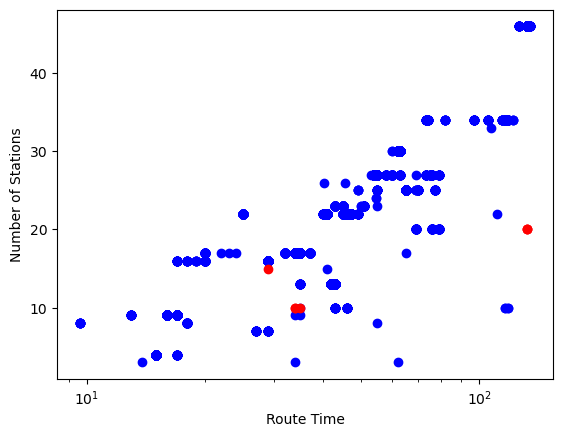

In [92]:
commuter_df = X_train[X_train["trainCategory_Commuter"] == True]

plt.scatter(commuter_df[commuter_df.LOF_20 == 0]["difference"],
            commuter_df[commuter_df.LOF_20 == 0]["numStations"], c = "blue")
plt.scatter(commuter_df[commuter_df.LOF_20 == 1]["difference"], 
            commuter_df[commuter_df.LOF_20 == 1]["numStations"], c = "red")

plt.xlabel("Route Time")
plt.ylabel("Number of Stations")
plt.xscale('log')
plt.show()

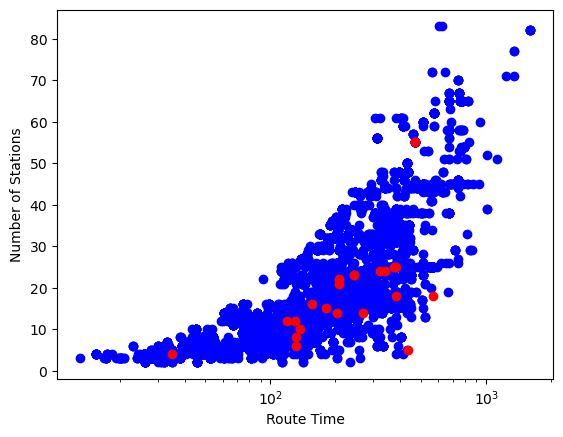

In [95]:

cargo_df = X_train[X_train["trainCategory_Cargo"] == True]

plt.scatter(cargo_df[cargo_df.LOF_20 == 0]["difference"],
            cargo_df[cargo_df.LOF_20 == 0]["numStations"], c = "blue")
plt.scatter(cargo_df[cargo_df.LOF_20 == 1]["difference"], 
            cargo_df[cargo_df.LOF_20 == 1]["numStations"], c = "red")

plt.xlabel("Route Time")
plt.ylabel("Number of Stations")
plt.xscale('log')
plt.show()

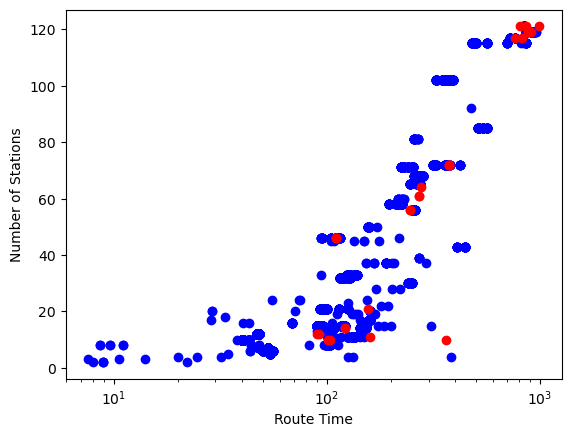

In [96]:

long_dist_df = X_train[X_train["trainCategory_Long-distance"] == True]

plt.scatter(long_dist_df[long_dist_df.LOF_20 == 0]["difference"],
            long_dist_df[long_dist_df.LOF_20 == 0]["numStations"], c = "blue")
plt.scatter(long_dist_df[long_dist_df.LOF_20 == 1]["difference"], 
            long_dist_df[long_dist_df.LOF_20 == 1]["numStations"], c = "red")

plt.xlabel("Route Time")
plt.ylabel("Number of Stations")
plt.xscale('log')
plt.show()

In [101]:
long_dist_df[long_dist_df.trainNumber == "266"]

,difference,numStations,cancelled,is_weekend,hour,isMin_18_19_March_2021,isMax_1_April_2021,trainCategory_Cargo,trainCategory_Commuter,trainCategory_Locomotive,...,trainCategory_Test drive,trainNumber,mad_NS,mad_D,KNN_5,LOF_5,KNN_10,LOF_10,KNN_20,LOF_20
2138,762.0,117.0,0,1,14,False,False,False,False,False,...,False,266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2118,762.0,117.0,0,0,15,False,False,False,False,False,...,False,266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2114,762.0,117.0,0,0,15,False,False,False,False,False,...,False,266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2137,759.0,117.0,0,1,15,False,False,False,False,False,...,False,266,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2119,762.0,117.0,0,0,15,False,False,False,False,False,...,False,266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2113,762.0,117.0,0,0,15,False,False,False,False,False,...,False,266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2117,762.0,117.0,0,1,15,False,False,False,False,False,...,False,266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2120,762.0,117.0,0,0,15,False,False,False,False,False,...,False,266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2112,762.0,117.0,0,0,15,False,False,False,False,False,...,False,266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2129,762.0,117.0,0,0,15,True,False,False,False,False,...,False,266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
long_dist_df[long_dist_df.trainNumber == "481"]

,difference,numStations,cancelled,is_weekend,hour,isMin_18_19_March_2021,isMax_1_April_2021,trainCategory_Cargo,trainCategory_Commuter,trainCategory_Locomotive,...,trainCategory_Test drive,trainNumber,mad_NS,mad_D,KNN_5,LOF_5,KNN_10,LOF_10,KNN_20,LOF_20
4177,159.0,17.0,0,0,10,False,False,False,False,False,...,False,481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4189,159.0,17.0,0,0,10,False,False,False,False,False,...,False,481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4180,159.0,17.0,0,1,10,False,False,False,False,False,...,False,481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4197,159.0,17.0,0,0,10,False,False,False,False,False,...,False,481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4183,159.0,17.0,0,0,10,False,False,False,False,False,...,False,481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4199,159.0,17.0,0,1,10,False,False,False,False,False,...,False,481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4191,159.0,11.0,12,0,10,True,False,False,False,False,...,False,481,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
4202,159.0,17.0,0,0,9,False,False,False,False,False,...,False,481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4176,159.0,17.0,0,0,10,False,False,False,False,False,...,False,481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4193,159.0,17.0,0,1,10,False,False,False,False,False,...,False,481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Conclusion

There were clearly many cancellations especially on the 18th and 19th around Helsinki.

Even though accidents are one of the mojor reasons for long delays, they don't seem to occur that often. Traffic management is the main reason for delays.

Most of the delays occur in the northern and southern parts of the rail ways. Most of the cancellations occur at the end of routes. 

Although most of the routes consist of commuter trains, the majority of deviations and anomalies in route duration and the number of stations are observed in the cargo train routes. Commuter trains are more consistent. Most of the anomalies are due to cancellations in each train route.

Even small deviations can be detected with anomaly analysis. 